# Earth System Data Lab Exercise - EO Summer School 2018

# Exercise 2: Interpret data cube anomalies by calculating mean seasonal cycle and plotting a Hovmöller Diagram
### earthsystemdatalab.net (provided by: MPI-BGC Jena & Brockman Consult GmbH)

In this task we ask you to make an effort to understand the anomalies of two variables of interest in the ESDL. Regarding the definition:

Question could be the following: 
* Where are the regions of strongest variability in the anomalies?
* What are the latitudinal gradients?
* How is the variability of the anomaly related to the mean seasonal cycle?
* Are the anomalies between two variables of interest strongly correlated?
* What is the timing of the strongest anomaly?
* Do these questions make sense with these data? What would be the right questions to ask and implement?


To achieve this, follow these steps:
* Import the necessary libraries
* Open ESDL Cube, select some variables
* Calculate anomaly
* Calculate mean seasonal cycle
* Plot Hovmöller Diagram 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from numpy import datetime64
from ipywidgets import interact 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Open the low-resolution data cube

There are two ways to achieve this. Either use native ESDL Data Access API:

In [2]:
#from esdl import Cube

#cube = Cube.open("/home/jovyan/work/datacube/esdc-8d-0.25deg-1x720x1440-1.0.1_1")
#ESDC = cube.data.dataset()    # this converts the cube object to xarray Dataset. It may take a while...

... or open the zarr version of the cube using xarray open_zarr function (this is only applicable to zarr cube (i.e. one with "zarr" suffix at the cube name)):

In [3]:
ESDC = xr.open_zarr("/home/jovyan/work/datacube/esdc-8d-0.25deg-1x720x1440-1.0.1_1_zarr")

**NOTE:** Zarr cube is still at experimental phase, so not all cubes have their equivalent zarr cubes

References:<br>
zarr: https://zarr.readthedocs.io/en/stable/<br>
xarray open dataset API: http://xarray.pydata.org/en/stable/api.html#dataset-methods

### Select the desired region with xarray.Dataset.sel() function

Reference: http://xarray.pydata.org/en/stable/generated/xarray.Dataset.sel.html#xarray.Dataset.sel

In [4]:
ESDC_Europe = ESDC.sel(lat = slice(70.,30.), lon = slice(-20.,35.))

### Plot single-image variable with time_index slider and variable drop-down list

First, compile all variable names in a list

In [5]:
var_names = []
for var_name in ESDC_Europe.data_vars:
    var_names.append(var_name)

And then, create a function to plot the variable. Here, we use **xarray.DataArray**, which is a wrapper to matplotlib library. In most cases, this is good enough to plot what we want to see, but for more sophisticated plotting, matplotlib has to be used. 

More info about xarray plot: http://xarray.pydata.org/en/stable/plotting.html

In [6]:
def plot_image(time_index=120, variable_name=var_names[12]):
    ESDC_Europe[variable_name][time_index].plot(figsize=(18,9), aspect='auto')

Use interact from ipywidgets by passing the plot function and specifying the allowable range of the passed variables. For example, on the following cell, **plot_image** function is passed with two arguments: 
* **time_index**: from 0 to max of ESDC_Europe.time - 1 with resolution of 1
* **variable_name**: a list of possible variable names

More info about ipywidgets: https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html 

In [7]:
interact(plot_image, time_index=(0,ESDC_Europe.time.size - 1,1), variable_name=var_names)

interactive(children=(IntSlider(value=120, description='time_index', max=505), Dropdown(description='variable_…

<function __main__.plot_image(time_index=120, variable_name='evaporative_stress')>

### Calculate standardized monthly anomalies

Ref: http://xarray.pydata.org/en/stable/examples/weather-data.html#calculate-standardized-monthly-anomalies

In [8]:
mean_europe = ESDC_Europe.groupby('time.dayofyear').mean('time')

In [9]:
europe_stand_anomalies = xr.apply_ufunc(lambda x, m: (x - m), ESDC_Europe.groupby('time.dayofyear'), mean_europe, dask='allowed')

In [10]:
def plot_anomalies(var1='air_temperature_2m', var2='soil_moisture'):
    plt.figure(figsize=(18,9))
    var1_plot, = plt.plot(ESDC_Europe.time, europe_stand_anomalies[var1].mean(['lat','lon']).to_dataframe()[[var1]])
    var2_plot, = plt.plot(ESDC_Europe.time, europe_stand_anomalies[var2].mean(['lat','lon']).to_dataframe()[[var2]])
    plt.legend([var1_plot, var2_plot],[var1, var2])
    plt.show()

In [11]:
interact(plot_anomalies, var1=var_names, var2=var_names)

interactive(children=(Dropdown(description='var1', index=5, options=('aerosol_optical_thickness_1610', 'aeroso…

<function __main__.plot_anomalies(var1='air_temperature_2m', var2='soil_moisture')>

In [12]:
vanom  = europe_stand_anomalies.var(dim="time")
vcycle = mean_europe.var(dim="dayofyear")

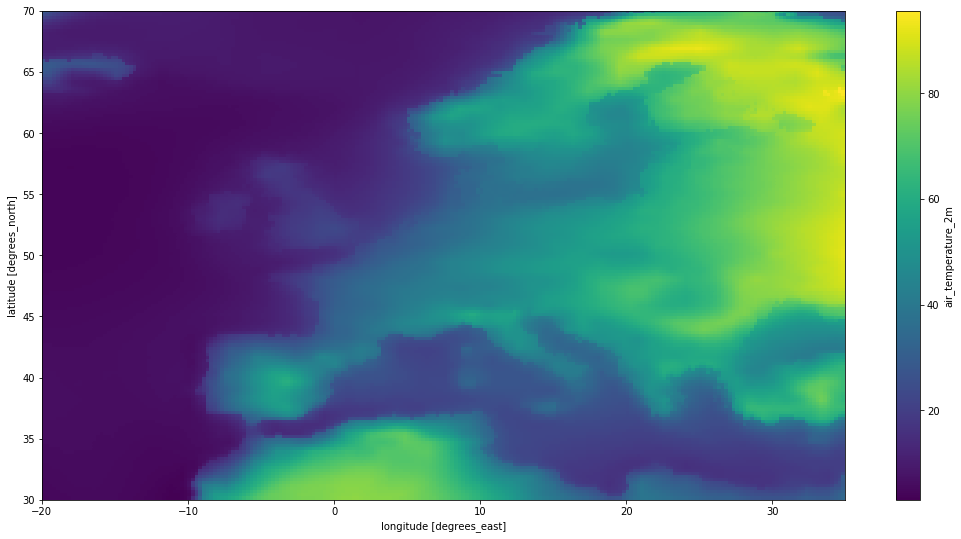

In [13]:
vcycle['air_temperature_2m'].plot(figsize=(18,9))

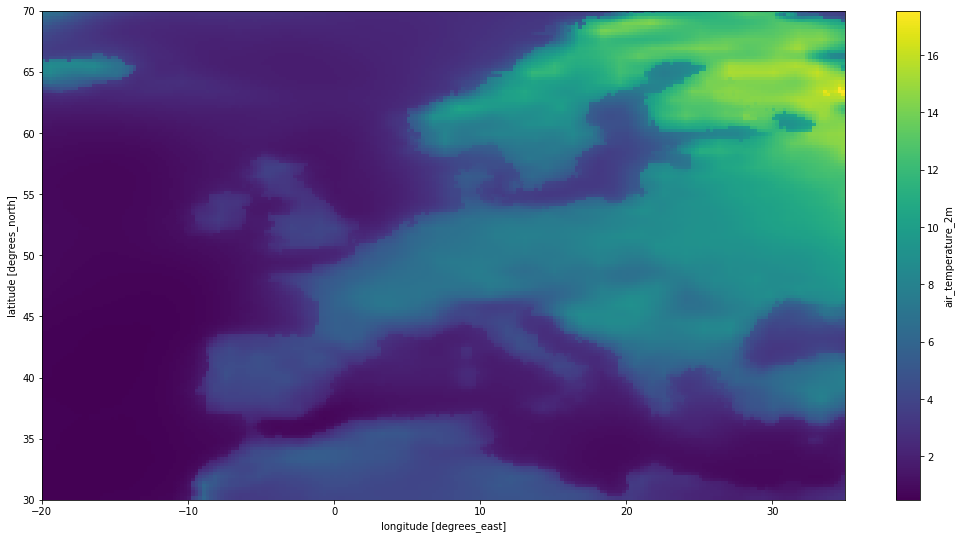

In [14]:
vanom['air_temperature_2m'].plot(figsize=(18,9))

In [15]:
def plot_scatter_anomalies(var1='air_temperature_2m'):
    plt.figure(figsize=(18,9))
    plt.scatter(vanom[var1].values.flatten(), vcycle[var1].values.flatten())
    plt.show()
interact(plot_scatter_anomalies, var1=var_names)

interactive(children=(Dropdown(description='var1', index=5, options=('aerosol_optical_thickness_1610', 'aeroso…

<function __main__.plot_scatter_anomalies(var1='air_temperature_2m')>

### Finally, plot Hovmöller diagram to see the latitudinal gradient

In [16]:
def plot_hovmoeller(latitude=0, var_name='air_temperature_2m'):
    plt.figure(figsize=(18,9))
    hovmoell = plt.contourf(mean_europe[var_name][:,latitude,:])
    plt.title('Hovmöller Plot at latitude ' + str(mean_europe.lat.isel(lat=latitude).values))
    plt.xlabel('Longitude')
    plt.ylabel('8-day period')
    cbar = plt.colorbar(hovmoell)
    cbar.ax.set_ylabel('mean ' + var_name)
    plt.show()

In [17]:
interact(plot_hovmoeller, latitude=(0,mean_europe.lat.size - 1,1), var_name=var_names)

interactive(children=(IntSlider(value=0, description='latitude', max=159), Dropdown(description='var_name', in…

<function __main__.plot_hovmoeller(latitude=0, var_name='air_temperature_2m')>